In [370]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [483]:
from camera import CameraReader, display_frame
import ipywidgets as widgets
import numpy as np
import sys
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import pywt
import time
from scipy.cluster.vq import vq
from sklearn.cluster import KMeans
from matplotlib import animation, patches
from scipy import fftpack
from scipy.signal import fftconvolve, convolve2d
from IPython.display import display, Audio, HTML
from style import *
from collections import Counter
%matplotlib notebook
plt.rcParams['image.cmap'] = 'gray'



In [372]:
def contar(matr):
    plano = np.ravel(matr.astype(np.uint8))
    return Counter(plano).most_common()

In [487]:
class Nodo:
    def __init__(self,hijo_izq,hijo_der):
        self.left = hijo_izq
        self.right = hijo_der
    def hijos(self):
        return (self.left,self.right)
    
def crear_arbol_de_Huffman(frecuencias):
    
    arbol_Hf = frecuencias
    #print(arbol_Hf)
    while len(arbol_Hf)>1:
        
        right,left = arbol_Hf[0],arbol_Hf[1]
        
        '''print("evaluar\n")
        print(right[0])
        print(right[1])
        print("\n")
        print(left[0])
        print(left[1])'''
        
        rm0x,rm0y = arbol_Hf[0][0],arbol_Hf[0][1]
        rm1x,rm1y = arbol_Hf[1][0],arbol_Hf[1][1]
    
        #if(len(arbol_Hf)>1):
        if(left[1]<right[1]):
            #print("aca\n")
            if(len(arbol_Hf)>2):
                aux1 = arbol_Hf[1]
                aux2 = arbol_Hf[2]
                arbol_Hf[2] = right
                left = aux2
                right = aux1
            else:
                aux = left
                left = right
                right = aux
            '''print("añadir\n")
            print(right[0])
            print(right[1])
            print("\n")
            print(left[0])
            print(left[1])''' 

        '''print("añadir\n")
        print(right[0])
        print(right[1])
        print("\n")
        print(left[0])
        print(left[1])'''
        nodo = Nodo(left,right)
        arbol_Hf.insert(0,(nodo,left[1]+right[1]))
        
        
        arbol_Hf.remove((rm0x,rm0y))
        arbol_Hf.remove((rm1x,rm1y))
        
        #print(arbol_Hf)
        #arbol_Hf = sorted(arbol_Hf,key=lambda l:l[1], reverse=False)
        #print(arbol_Hf)
        
        
        #print(arbol_Hf)
    #print("\n")
    return arbol_Hf
        
def recorrer_arbol(nodo, prefijo="", codigo={}):
    #print(nodo[0][0])
    #print(nodo[0][1])
    if isinstance(nodo[0].left[0],Nodo):
        recorrer_arbol(nodo[0].left,prefijo+"1",codigo)
    else:
        codigo[nodo[0].left[0]]=prefijo+"1"
    if isinstance(nodo[0].right[0],Nodo):
        recorrer_arbol(nodo[0].right,prefijo+"0",codigo)
    else:
        codigo[nodo[0].right[0]]=prefijo+"0"
    
    return codigo
    

In [452]:
def replica(matrix,N=2):
    x = np.repeat(matrix[:,],N,axis=1)
    return np.repeat(x,N,axis=0)
def lh_replicada(matrix):
    matrix[1::2,:] = matrix[1::2,:]*-1
    return matrix
def hl_replicada(matrix):
    matrix[:,1::2] = matrix[:,1::2]*-1
    return matrix
def hh_replicada(matrix):
    matrix[::2,1::2] = matrix[::2,1::2]*-1
    matrix[1::2,::2] = matrix[1::2,::2]*-1
    return matrix

def inversa(LL,LH,HL,HH):
    LLrep = replica(LL)
    
    LHrep = lh_replicada(replica(LH))
    
    HLrep = hl_replicada(replica(HL))
    HHrep = hh_replicada(replica(HH))
    return LLrep + LHrep + HLrep + HHrep

In [446]:
def Cuantizacion(x,h=8):
    return (x//h)*h + (h//2)

In [447]:
def LowRow(image):
    lowRowImage = np.zeros(shape=(image.shape[0],image.shape[1]//2))
    contt = 0
    for i in range(0,image.shape[1],2):
        lowRowImage[:,contt:contt+1] = (image[:,i:i+1] + image[:,i+1:i+2])/2
        contt += 1
    
    """for i in range(0,image.shape[0]):    
        cont = 0
        for j in range(0, image.shape[1],2):
            lowRowImage[i][cont] = ((image[i][j] + image[i][j+1]) / 2)
            if(lowRowImage[i][cont] < 0.9):
                lowRowImage[i][cont] = 0;
            cont += 1"""
    return np.clip(lowRowImage,1,255)

def LowCol(image):
    lowColImage = np.zeros(shape=(image.shape[0]//2,image.shape[1]))
    contt = 0
    for i in range(0,image.shape[0],2):
        lowColImage[contt:contt+1,:] = (image[i:i+1,:] + image[i+1:i+2,:])/2
        contt += 1
    
    
    """for j in range(0,image.shape[1]):
        cont = 0
        for i in range(0, image.shape[0], 2):
            lowColImage[cont][j] = ((image[i][j] + image[i+1][j]) / 2)
            if(lowColImage[cont][j] < 0.9):
                lowColImage[cont][j] = 0;
            cont += 1"""
    return np.clip(lowColImage,1,255)

def HighRow(image):
    lowRowImage = LowRow(image)
    highRowImage = np.zeros(shape=lowRowImage.shape)
    for i in range(0,lowRowImage.shape[1]):
        highRowImage[:,i:i+1] = image[:,2*i:(2*i)+1] - lowRowImage[:,i:i+1]
        
    """for i in range(0,image.shape[0]):
        cont = 0
        for j in range(0,lowRowImage.shape[1]):
            highRowImage[i][cont] = image[i][2*j] - lowRowImage[i][j]
            if(highRowImage[i][cont] < 0.9):
                highRowImage[i][cont] = 0;
            cont += 1"""
    return np.clip(highRowImage,1,255)

def HighCol(image):
    lowColImage = LowCol(image)
    highColImage = np.zeros(shape=lowColImage.shape)
    for i in range(0,lowColImage.shape[0]):
        highColImage[i:i+1,:] = image[2*i:(2*i)+1,:] - lowColImage[i:i+1,:]
        
    """for j in range(0,image.shape[1]):
        cont = 0
        for i in range(0,lowColImage.shape[0]):
            highColImage[cont][j] = image[i*2][j] - lowColImage[i][j]
            if(highColImage[cont][j] < 0.9):
                highColImage[cont][j] = 0;
            cont += 1"""
    return np.clip(highColImage,1,255)

In [491]:
def limpiar_filtro(frame,size_y,size_x):
    c_y, c_x = frame.shape[0]/2,frame.shape[1]/2
    x_v = np.arange(0, frame.shape[1]); y_v = np.arange(0, frame.shape[0]);
    X, Y = np.meshgrid(x_v, y_v)
    sigma = 200
    mask = 1e-8 + np.exp(-(((X-c_x)/sigma/0.9)**2 + ((Y-c_y)/sigma/0.6)**2))
    frame_limpio = fftpack.fftshift(fftpack.fft2(frame))*mask
    frame_limpio[240-size_y-1-frequency:240+size_y-1-frequency, 420-size_x+2:420+size_x+2] = 0
    frame_limpio[240-size_y-1+frequency:240+size_y+1+frequency, 420-size_x+6:420+size_x+6] = 0
    frame_ret = np.abs(fftpack.ifft2(fftpack.ifftshift(frame_limpio)))
    return frame_ret

def play_vid(frame_list,size_y,size_x):
    count = 0
    #display(out)
    for frame in cam:
        limpio = limpiar_filtro(frame,size_y,size_x)
        #scipy.misc.imsave("frame_sp/sp{0}.jpg".format(count),limpio)
        #frame_list.append(limpio.astype(np.uint8))
        
        lowRow = LowRow(limpio)
        highRow = HighRow(limpio)
    
        LL = LowCol(lowRow)
        LH = HighCol(lowRow)
        HL = LowCol(highRow)
        HH = HighCol(highRow)
    
        n = 1
    
        LL = Cuantizacion(LL,n)
        LH = Cuantizacion(LH,n)
        HL = Cuantizacion(HL,n)
        HH = Cuantizacion(HH,n)
        
        #print(sys.getsizeof(frame_limpio))  #getsizeof retorna el tamaño en Bytes

        # Implemente una función que comprima los frames
        freq_LL = contar(LL)
        freq_LH = contar(LH)
        freq_HL = contar(HL)
        freq_HH = contar(HH)
        #print(freq_LL)
        #print(freq_LL[::-1])
        LL_HF = crear_arbol_de_Huffman(freq_LL[::-1])
        code_LL = recorrer_arbol(LL_HF[0])
        LH_HF = crear_arbol_de_Huffman(freq_LH[::-1])
        code_LH = recorrer_arbol(LH_HF[0])
        HL_HF = crear_arbol_de_Huffman(freq_HL[::-1])
        code_HL = recorrer_arbol(HL_HF[0])
        #print(freq_HH)
        HH_HF = crear_arbol_de_Huffman(freq_HH[::-1])
        #print(HH_HF)
        if(len(HH_HF)>1):
            code_HH = recorrer_arbol(HH_HF[0])
        else:
            nodo = Nodo(None,None)
            code_HH = [(nodo,0)]
        #print("\n")
        #print(code_LL)
        # frame_comprimido = comprimir(frame)
        # print(sys.getsizeof(frame_comprimido))

        # Implemente una función que descomprima los frames
        # frame = descomprimir(frame_compromido)
        # print(cam.error(frame))  # Error de compresión
        
        result = inversa(LL,LH,HL,HH)
        #display_frame(out, result.astype(np.uint8))
        frame_list.append(result.astype(np.uint8))
        count +=1;

        #if(count==1):
        #    break;
    return frame_list,count    

def play_sp(out,cam):
    count = 0
    for i in cam:
        im = scipy.misc.imread("frame_sp/sp{0}.jpg".format(count))
        display_frame(out,im)
        count 

Iniciando lector de camara
OpenCV version: major: 4, minor: 1, subminor: 0
Resolución del video: 848x480p
Cuadros por segundo: 29.97002997002997



<IPython.core.display.Javascript object>


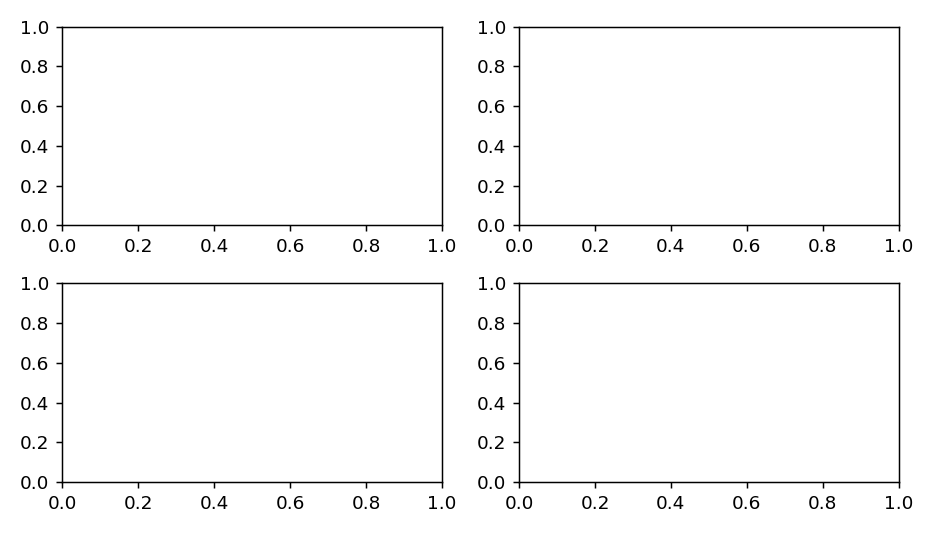

Total =  196.17915987968445 segundos
4.587643257071571 FPS


In [492]:
cam = CameraReader()
vid_height, vid_width = cam.get_resolution()
print("Resolución del video: {0}x{1}p".format(vid_width, vid_height))
print("Cuadros por segundo: {0}".format(cam.get_fps()))
print()
out = widgets.Image(layout=widgets.Layout(width=str(vid_width), 
                                           height=str(vid_height)))

fig, ax = plt.subplots(2, 2, figsize=(7,4), tight_layout=True)

size_y=10
size_x=2
frequency=28
frame_list = [[]]
time1 = time.time()

frame_list,count = play_vid(frame_list,size_y,size_x)

time2 = time.time()
print("Total = ", time2 - time1, "segundos")
print(count/(time2-time1),"FPS")
#play_sp(out,cam)

#print(sys.getsizeof(frame_list[0]))

#Salidas en plot
#print("Tamaño frame comprimido: %0.2f MB" %(np.sum(nnz)*8/1e+6))
#print("{0} MB".format(sys.getsizeof(frame)/1e6))
#print("{0} MB".format(sys.getsizeof(frame_revuelto)/1e6))
#print("{0} MB".format(sys.getsizeof(frame_list)/1e6))

In [ ]:
#fftpack.fftshift(np.log(1+np.abs(fftpack.fft2(frame.astype('float32')))))